In [82]:
import pickle
import tensorflow as tf
import keras
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import numpy as np
import os, shutil, pathlib

In [2]:
# Load train and validation images
dataroot = "dataroot/"
train_data = pickle.load(open(dataroot+"train.p", "rb" ))
val_data = pickle.load(open(dataroot+"valid.p", "rb"))

X_train_original, y_train = train_data['features'], train_data['labels']
X_val_original, y_val = val_data['features'], val_data['labels']

def resize_images(images, new_size):
    resized_images = tf.image.resize(images, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return resized_images

new_size = (128, 128)
X_train = resize_images(X_train_original, new_size).numpy()
X_val = resize_images(X_val_original, new_size).numpy()

print(X_train.shape)
print(X_val.shape)

my_input_shape = X_train.shape[1:]
my_input_shape

# One-hot encode
num_classes = 43
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

2024-07-15 07:40:35.816201: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NOT_FOUND: named symbol not found
2024-07-15 07:40:35.868205: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1710440448 exceeds 10% of free system memory.


(34799, 128, 128, 3)
(4410, 128, 128, 3)


In [53]:
def make_graphs(hist, title):
    epochs = len(hist.history['loss'])
    fig, axes = plt.subplots(2, 1, figsize=(10, 16))
    fig.suptitle(title, fontsize=16)
    make_graph_loss(hist, epochs, axes[0])
    make_graphs_accuracy(hist, epochs, axes[1])
    plt.tight_layout()

def make_graph_loss(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    sns.lineplot(x=eps, y=train_loss, color='b', label='Training Loss', ax=ax)
    sns.lineplot(x=eps, y=val_loss, color='r', label='Validation Loss', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    ax.legend()
    ax.grid(True)
    

def make_graphs_accuracy(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    sns.lineplot(x=eps[1:], y=train_acc[1:], color='b', label='Training Accuracy', ax=ax)
    sns.lineplot(x=eps[1:], y=val_acc[1:], color='r', label='Validation Accuracy', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training vs Validation Accuracy')
    ax.legend()
    ax.grid(True)
    ax.yaxis.set_major_locator(MultipleLocator(0.02))
    ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)

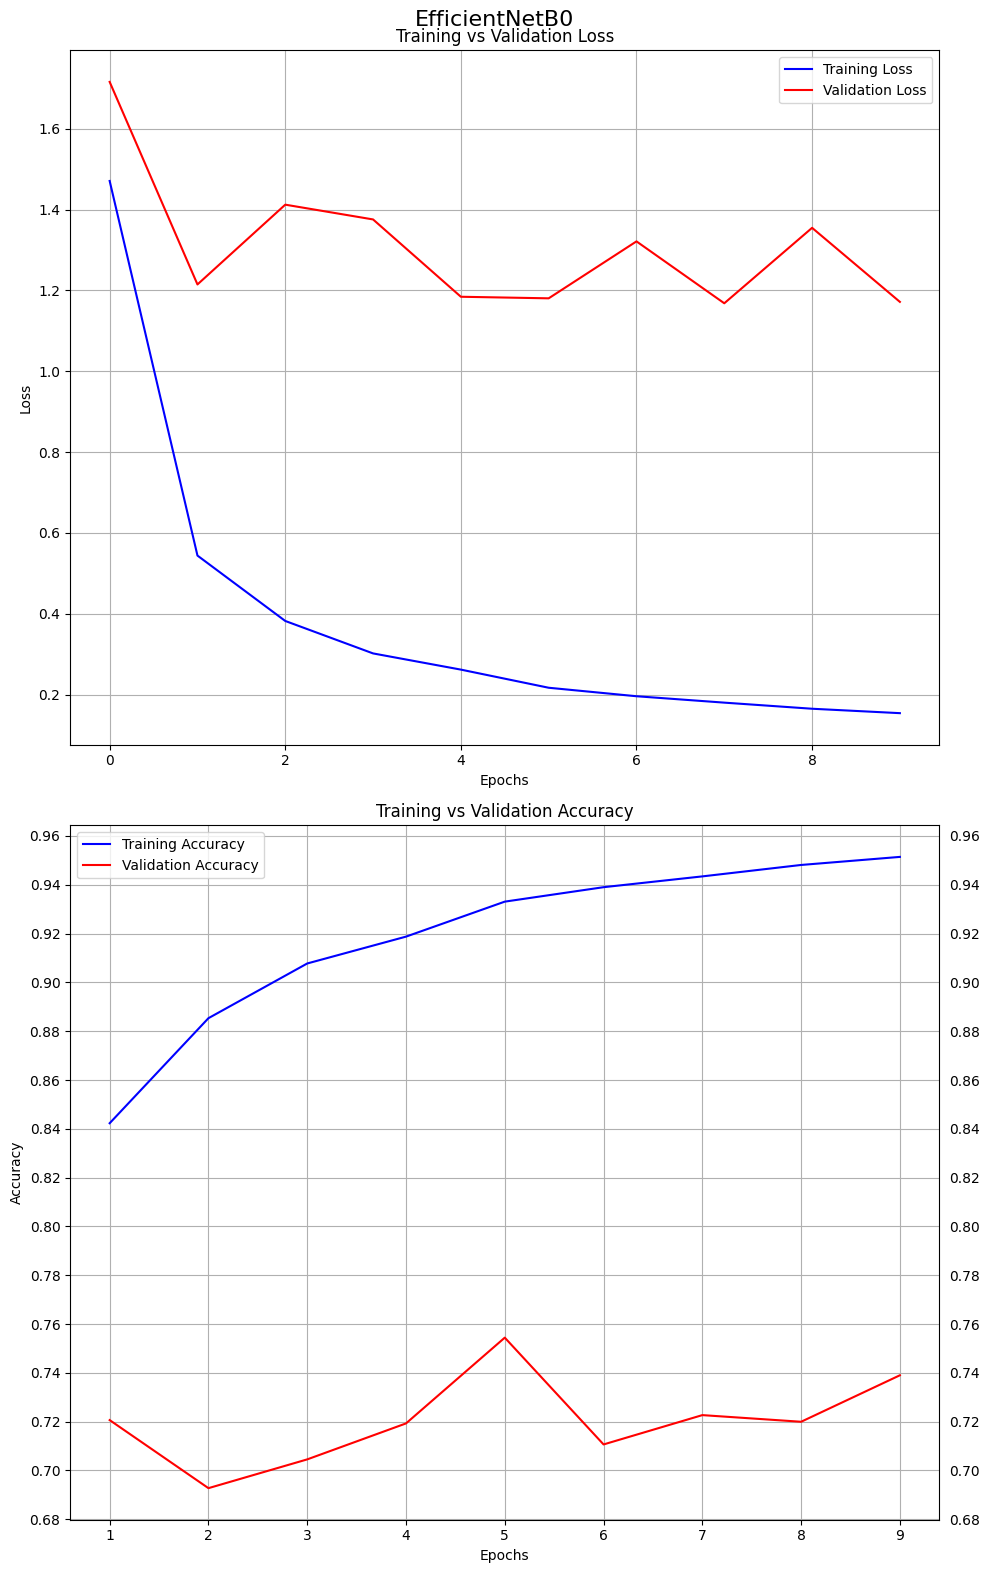

In [54]:
def graph():
    make_graphs(EfficientNetB0_hist, "EfficientNetB0")
graph()

In [4]:
# baseline accuracy was about 70%

# add early stopping
# save the best model to current_model.keras

# first, add a dense layer with 64 neurons

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])


callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_loss', 
    mode='min', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=0)


2024-07-15 07:40:51.485316: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1710440448 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 3.00152, saving model to current_model.keras

Epoch 2: val_loss improved from 3.00152 to 2.31541, saving model to current_model.keras

Epoch 3: val_loss improved from 2.31541 to 2.16178, saving model to current_model.keras

Epoch 4: val_loss improved from 2.16178 to 2.03267, saving model to current_model.keras

Epoch 5: val_loss did not improve from 2.03267

Epoch 6: val_loss did not improve from 2.03267

Epoch 7: val_loss did not improve from 2.03267

Epoch 8: val_loss did not improve from 2.03267

Epoch 9: val_loss did not improve from 2.03267

Epoch 10: val_loss did not improve from 2.03267


In [9]:
# try 128 neurons with 0.5 dropout
# monitor accuracy instead of loss

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])


callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=1)


Epoch 1/10


2024-07-15 08:18:07.499605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1710440448 exceeds 10% of free system memory.


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5158 - loss: 5.6767
Epoch 1: val_accuracy improved from -inf to 0.64921, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 202s 182ms/step - accuracy: 0.5159 - loss: 5.6749 - val_accuracy: 0.6492 - val_loss: 2.9701
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7705 - loss: 1.6968
Epoch 2: val_accuracy improved from 0.64921 to 0.69705, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 193s 177ms/step - accuracy: 0.7705 - loss: 1.6966 - val_accuracy: 0.6971 - val_loss: 2.7978
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8239 - loss: 1.0745
Epoch 3: val_accuracy improved from 0.69705 to 0.72925, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 195s 179ms/step - accuracy: 0.8239 - loss: 1.0745 - val_accuracy: 0.7293 - val_loss: 2.6346
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8504 - loss: 0.8281
Epoch 4: 

In [43]:
# try 32 neurons with 0.2 dropout

EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
x = layers.Dense(32)(x)
x = layers.Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])


callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=1)


Epoch 1/10


2024-07-15 09:03:20.154738: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1710440448 exceeds 10% of free system memory.


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5537 - loss: 2.3954
Epoch 1: val_accuracy improved from -inf to 0.65420, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 185s 166ms/step - accuracy: 0.5538 - loss: 2.3946 - val_accuracy: 0.6542 - val_loss: 1.7157
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8320 - loss: 0.5861
Epoch 2: val_accuracy improved from 0.65420 to 0.72063, saving model to current_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 176s 162ms/step - accuracy: 0.8320 - loss: 0.5861 - val_accuracy: 0.7206 - val_loss: 1.2147
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8810 - loss: 0.3906
Epoch 3: val_accuracy did not improve from 0.72063
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 185s 170ms/step - accuracy: 0.8810 - loss: 0.3905 - val_accuracy: 0.6927 - val_loss: 1.4120
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9073 - loss: 0.3061
Epoch 4: val_accuracy did not improve from 0.72063

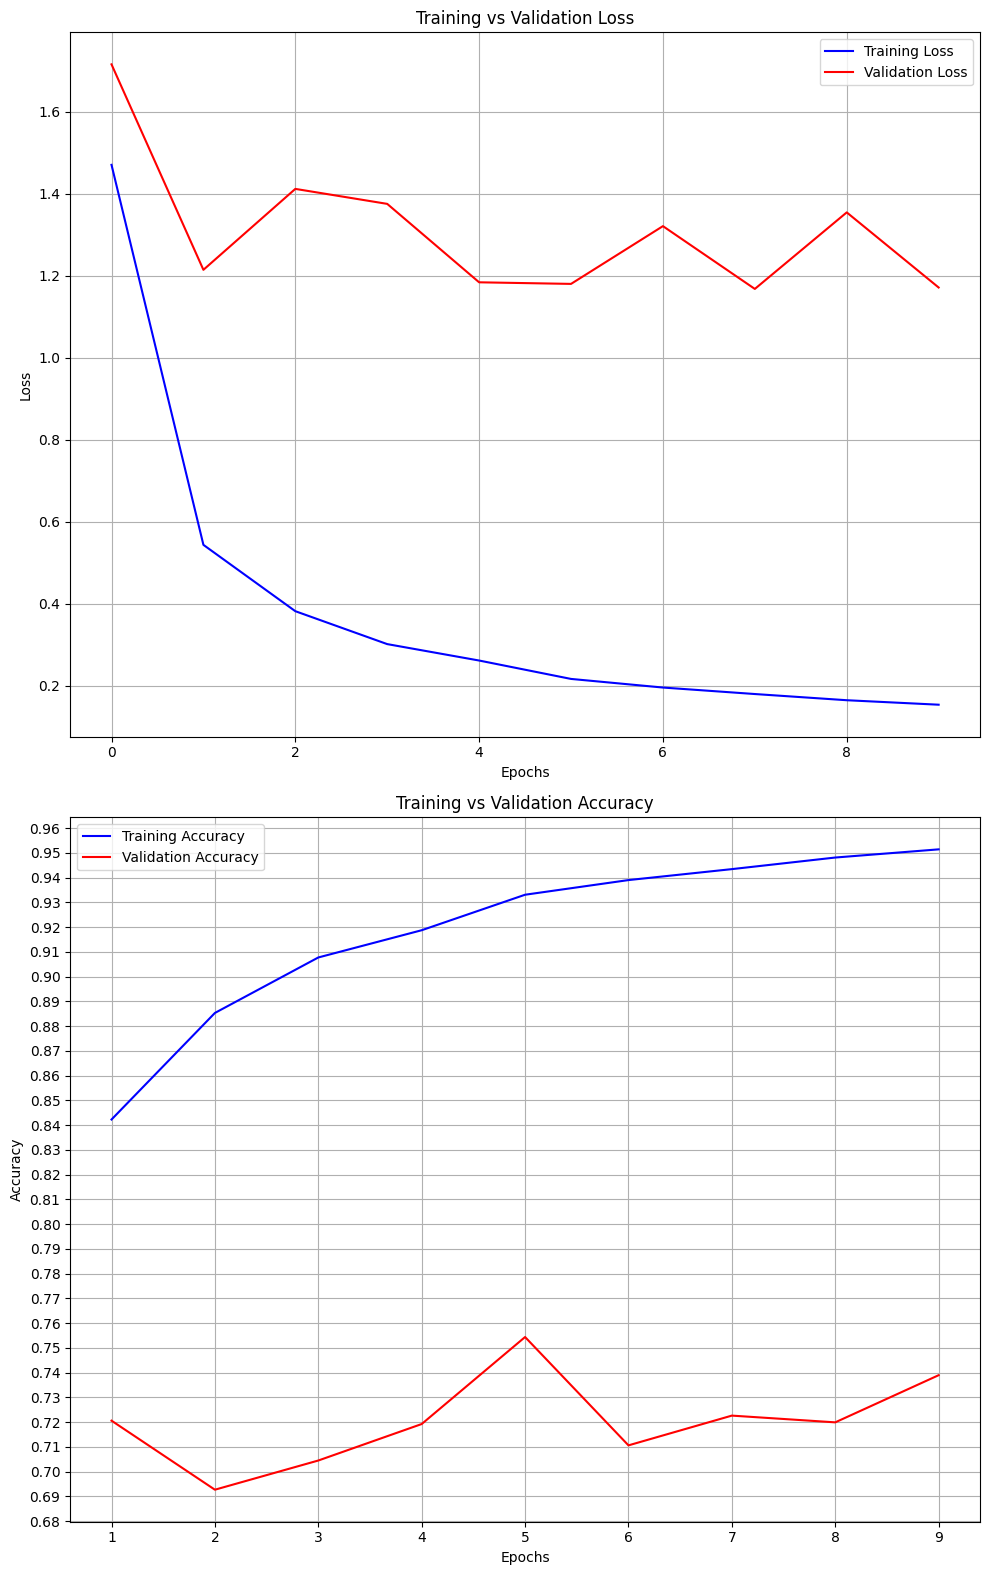

In [48]:
EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
EfficientNetB0_base.trainable = False

x = EfficientNetB0_base.output
x = layers.Flatten()(x)
x = layers.Dense(32)(x)
x = layers.Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                             optimizer="rmsprop",
                             metrics=["accuracy"])


callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='current_model.keras', 
    save_best_only=True, 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1
)

EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                               batch_size=32,
                                               epochs=10,
                                               validation_data=(X_val, y_val),
                                               callbacks = [callback, model_checkpoint],
                                               verbose=1)

In [86]:
best_val_accuracy = max(EfficientNetB0_hist.history['val_accuracy'])
print(best_val_accuracy)
EfficientNetB0_Model.save('global_best_model.keras')

best_params = {}

0.7544217705726624


In [87]:
# Grid search

param_grid = {
    'neurons': [32, 64, 128],
    'dropout_rate': [0.0, 0.2, 0.5]
}

for neurons in param_grid['neurons']:
    for dropout_rate in param_grid['dropout_rate']:
        print(f"Training with neurons={neurons}, dropout_rate={dropout_rate}")

        EfficientNetB0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=my_input_shape)
        EfficientNetB0_base.trainable = False

        x = EfficientNetB0_base.output
        x = layers.Flatten()(x)
        x = layers.Dense(neurons, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        EfficientNetB0_Model = Model(inputs=EfficientNetB0_base.input, outputs=predictions)
        EfficientNetB0_Model.compile(loss="categorical_crossentropy",
                                     optimizer="rmsprop",
                                     metrics=["accuracy"])

        callback= keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            filepath='current_model.keras', 
            save_best_only=True, 
            monitor='val_accuracy', 
            mode='max', 
            verbose=0
        )
        
        EfficientNetB0_hist = EfficientNetB0_Model.fit(X_train, y_train,
                                                       batch_size=32,
                                                       epochs=15,
                                                       validation_data=(X_val, y_val),
                                                       callbacks = [callback, model_checkpoint],
                                                       verbose=0)

        val_accuracy = max(EfficientNetB0_hist.history['val_accuracy'])
        print(f"Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'neurons': neurons, 'dropout_rate': dropout_rate}
            EfficientNetB0_Model.save('global_best_model.keras')

print(f"Best Validation Accuracy: {best_val_accuracy} with params: {best_params}")

Training with neurons=32, dropout_rate=0.0
Validation Accuracy: 0.7029478549957275
Training with neurons=32, dropout_rate=0.2
Validation Accuracy: 0.6757369637489319
Training with neurons=32, dropout_rate=0.5
Validation Accuracy: 0.44512471556663513
Training with neurons=64, dropout_rate=0.0
Validation Accuracy: 0.7451246976852417
Training with neurons=64, dropout_rate=0.2
Validation Accuracy: 0.6954648494720459
Training with neurons=64, dropout_rate=0.5
Validation Accuracy: 0.5925170183181763
Training with neurons=128, dropout_rate=0.0
Validation Accuracy: 0.7185941338539124
Training with neurons=128, dropout_rate=0.2
Validation Accuracy: 0.7192744016647339
Training with neurons=128, dropout_rate=0.5
Validation Accuracy: 0.6580498814582825
Best Validation Accuracy: 0.7544217705726624 with params: {}


In [ ]:
# nothing in the grid search was better than the run beforehand, which was 
# neurons=32, dropout_rate=0.2
# for whatever reason, the performance during the grid search was much worse (0.6757)

# neurons=64, dropout_rate=0.0
# also performed pretty well.

In [ ]:
# Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)